In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import mat73
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

from scipy.signal import find_peaks
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import r2_score
import psutil
import os
import time

In [2]:
wandb.login()
# run = wandb.init(project="master-multicomponent-mri", name="unet-baseline-fullpatch")
run = wandb.init(project="master-multicomponent-mri", name="unet-baseline-fullpatch-improved")

wandb: Currently logged in as: tr-phan (trphan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
data = mat73.loadmat('../../data/training_data_T1_3D_9x9x32x47932_noise0.05.mat')
input_noisy_np = data['input_noisy']
input_clean_np = data['input']
ref_np = data['ref']

print("Shape of input data:", input_noisy_np.shape)
print("Shape of reference data:", ref_np.shape)

Shape of input data: (9, 9, 8, 47932)
Shape of reference data: (9, 9, 32, 47932)


In [4]:
nan_count_input_noisy_before = np.isnan(input_noisy_np).sum()
nan_count_ref_before = np.isnan(ref_np).sum()
print(f"NaN count in input_noisy before handling: {nan_count_input_noisy_before}")
print(f"NaN count in ref before handling: {nan_count_ref_before}")

NaN count in input_noisy before handling: 1635840
NaN count in ref before handling: 0


In [5]:
input_noisy_np = np.nan_to_num(input_noisy_np, nan=0.0)
nan_count_input_noisy_after = np.isnan(input_noisy_np).sum()
print(f"NaN count in input_noisy after handling: {nan_count_input_noisy_after}")

NaN count in input_noisy after handling: 0


In [6]:
class T1PatchDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx]

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv1 = DoubleConv(8, 64)
        self.pool1 = nn.MaxPool2d(2, padding=1)
        self.conv2 = DoubleConv(64, 128)
        
        self.bridge_conv = DoubleConv(128, 256)
        
        self.upconv = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(192, 128)
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Conv2d(64, 32, kernel_size=1)
        )
        
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        
        conv1 = self.conv1(x)           # [batch, 64, 9, 9]
        x = self.pool1(conv1)           # [batch, 64, 5, 5]
        conv2 = self.conv2(x)           # [batch, 128, 5, 5]
        
        x = self.bridge_conv(conv2)     # [batch, 256, 5, 5]
        
        x = self.upconv(x)              # [batch, 128, 10, 10]
        x = x[:, :, :9, :9]            # [batch, 128, 9, 9]
        x = torch.cat([x, conv1], dim=1)  # [batch, 192, 9, 9]
        x = self.conv3(x)               # [batch, 128, 9, 9]
        
        x = self.final_conv(x)          # [batch, 32, 9, 9]
        
        return x

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-6, path='saved_models/best_unet_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [ ]:
# Transpose the input and reference data to be (N, C, H, W) format
input_noisy_torch = np.transpose(input_noisy_np, (3, 2, 0, 1))
ref_torch = np.transpose(ref_np, (3, 2, 0, 1))

input_noisy_torch = torch.tensor(input_noisy_torch, dtype=torch.float32)
ref_torch = torch.tensor(ref_torch, dtype=torch.float32)

In [10]:
input_mean = input_noisy_torch.mean()
input_std = input_noisy_torch.std()
input_noisy_torch = (input_noisy_torch - input_mean) / input_std

In [ ]:
# Create Dataset
dataset = T1PatchDataset(input_noisy_torch, ref_torch)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
early_stopping = EarlyStopping(patience=15, path='best_unet_model.pt')

num_epochs = 200

d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
# Log configuration
wandb.config.update({
    "learning_rate": 0.001,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "architecture": "UNet",
    "optimizer": "Adam",
    "loss_function": "MSELoss",
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": 15
})

In [14]:
# Training loop
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    
    for inputs, targets in progress_bar_train:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        progress_bar_train.set_postfix({'loss': loss.item()})

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
    
    with torch.no_grad():
        for inputs, targets in progress_bar_val:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            progress_bar_val.set_postfix({'loss': loss.item()})

    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Early stopping
    early_stopping(avg_val_loss, model)

    # Logging
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "learning_rate": current_lr
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, LR: {current_lr}')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print("Training finished")

Epoch [1/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 228.77it/s, loss=0.00544]


Epoch [1/200], Train Loss: 0.0161839753195333, Val Loss: 0.004231628687120974, LR: 0.001


Epoch [2/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 238.77it/s, loss=0.00307]


Epoch [2/200], Train Loss: 0.0029081797626956053, Val Loss: 0.002691191830672324, LR: 0.001


Epoch [3/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 227.64it/s, loss=0.648] 


EarlyStopping counter: 1 out of 15
Epoch [3/200], Train Loss: 0.002619307041944315, Val Loss: 0.593858770330747, LR: 0.001


Epoch [4/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 242.06it/s, loss=0.00316]


EarlyStopping counter: 2 out of 15
Epoch [4/200], Train Loss: 0.002832197194608549, Val Loss: 0.0027554091950878503, LR: 0.001


Epoch [5/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 233.57it/s, loss=0.00272]


Epoch [5/200], Train Loss: 0.0025139560300158335, Val Loss: 0.0024130086492126185, LR: 0.001


Epoch [6/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 220.87it/s, loss=0.00304]


EarlyStopping counter: 1 out of 15
Epoch [6/200], Train Loss: 0.0024108371276330824, Val Loss: 0.0025615653938924274, LR: 0.001


Epoch [7/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 228.94it/s, loss=0.00288]


Epoch [7/200], Train Loss: 0.0023492847879727683, Val Loss: 0.0023964873786705234, LR: 0.001


Epoch [8/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 232.23it/s, loss=0.00302]


EarlyStopping counter: 1 out of 15
Epoch [8/200], Train Loss: 0.002296297752376025, Val Loss: 0.002518526892332981, LR: 0.001


Epoch [9/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 235.20it/s, loss=0.00491]


EarlyStopping counter: 2 out of 15
Epoch [9/200], Train Loss: 0.002255913673628432, Val Loss: 0.0038936267420649527, LR: 0.001


Epoch [10/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 242.04it/s, loss=0.00505]


EarlyStopping counter: 3 out of 15
Epoch [10/200], Train Loss: 0.0022376572837432226, Val Loss: 0.0039561006954560675, LR: 0.001


Epoch [11/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.60it/s, loss=0.00313]


EarlyStopping counter: 4 out of 15
Epoch [11/200], Train Loss: 0.002193222512335827, Val Loss: 0.0026768223910282056, LR: 0.001


Epoch [12/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.09it/s, loss=0.00283]


EarlyStopping counter: 5 out of 15
Epoch [12/200], Train Loss: 0.0021673013306766128, Val Loss: 0.002395569980144501, LR: 0.001


Epoch [13/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.87it/s, loss=0.004]  


EarlyStopping counter: 6 out of 15
Epoch [13/200], Train Loss: 0.0021309613403476153, Val Loss: 0.0031806663990331194, LR: 0.001


Epoch [14/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 218.57it/s, loss=0.0179] 


EarlyStopping counter: 7 out of 15
Epoch [14/200], Train Loss: 0.0021107917494373398, Val Loss: 0.013455964170085887, LR: 0.001


Epoch [15/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 225.08it/s, loss=0.0032] 


EarlyStopping counter: 8 out of 15
Epoch [15/200], Train Loss: 0.0022511455397276827, Val Loss: 0.0027268887070628503, LR: 0.001


Epoch [16/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 226.42it/s, loss=0.0027] 


EarlyStopping counter: 9 out of 15
Epoch [16/200], Train Loss: 0.002106274133354115, Val Loss: 0.0024076966809419295, LR: 0.001


Epoch [17/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 214.29it/s, loss=0.00254]


Epoch [17/200], Train Loss: 0.0020786161967165147, Val Loss: 0.0022344974149018527, LR: 0.001


Epoch [18/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 216.90it/s, loss=0.0049] 


EarlyStopping counter: 1 out of 15
Epoch [18/200], Train Loss: 0.0020496150886174292, Val Loss: 0.0038259633056198557, LR: 0.001


Epoch [19/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 226.38it/s, loss=0.00229]


Epoch [19/200], Train Loss: 0.002041120933718048, Val Loss: 0.0021724177322660883, LR: 0.001


Epoch [20/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 216.64it/s, loss=0.00306]


EarlyStopping counter: 1 out of 15
Epoch [20/200], Train Loss: 0.0020084069199704877, Val Loss: 0.0025771788080843788, LR: 0.001


Epoch [21/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.82it/s, loss=0.00262]


EarlyStopping counter: 2 out of 15
Epoch [21/200], Train Loss: 0.001987225755583495, Val Loss: 0.0023467106899867454, LR: 0.001


Epoch [22/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 224.98it/s, loss=0.00248]


EarlyStopping counter: 3 out of 15
Epoch [22/200], Train Loss: 0.00197143507306464, Val Loss: 0.0021780065540224314, LR: 0.001


Epoch [23/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.28it/s, loss=0.00218]


Epoch [23/200], Train Loss: 0.0020482705525743466, Val Loss: 0.00206743464882796, LR: 0.001


Epoch [24/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 220.79it/s, loss=0.0022] 


Epoch [24/200], Train Loss: 0.0019578401878243314, Val Loss: 0.002047855739171306, LR: 0.001


Epoch [25/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 223.64it/s, loss=0.0638]


EarlyStopping counter: 1 out of 15
Epoch [25/200], Train Loss: 0.0019524453008004153, Val Loss: 0.061323655042797326, LR: 0.001


Epoch [26/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.25it/s, loss=0.00217]


Epoch [26/200], Train Loss: 0.0020812994796627514, Val Loss: 0.001991343287130197, LR: 0.001


Epoch [27/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.26it/s, loss=0.00201]


Epoch [27/200], Train Loss: 0.0019387569930404424, Val Loss: 0.0018964018975384533, LR: 0.001


Epoch [28/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 221.32it/s, loss=0.00205]


EarlyStopping counter: 1 out of 15
Epoch [28/200], Train Loss: 0.001918239432464664, Val Loss: 0.001911476949850718, LR: 0.001


Epoch [29/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 222.97it/s, loss=0.0021] 


EarlyStopping counter: 2 out of 15
Epoch [29/200], Train Loss: 0.001897687809347796, Val Loss: 0.001954545290209353, LR: 0.001


Epoch [30/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 158.67it/s, loss=0.00203]


EarlyStopping counter: 3 out of 15
Epoch [30/200], Train Loss: 0.0018929614815472937, Val Loss: 0.001909025990559409, LR: 0.001


Epoch [31/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 194.24it/s, loss=0.00242]


EarlyStopping counter: 4 out of 15
Epoch [31/200], Train Loss: 0.0018689068841437498, Val Loss: 0.0022253962055159113, LR: 0.001


Epoch [32/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 172.61it/s, loss=0.00201]


Epoch [32/200], Train Loss: 0.0018708067742409184, Val Loss: 0.0018748708829904597, LR: 0.001


Epoch [33/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 223.38it/s, loss=0.00206]


EarlyStopping counter: 1 out of 15
Epoch [33/200], Train Loss: 0.0018599025812000036, Val Loss: 0.001958502147657176, LR: 0.001


Epoch [34/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 245.96it/s, loss=0.00196]


Epoch [34/200], Train Loss: 0.0018516294617438689, Val Loss: 0.0018558622027436892, LR: 0.001


Epoch [35/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 243.89it/s, loss=0.00235]


EarlyStopping counter: 1 out of 15
Epoch [35/200], Train Loss: 0.0018400994047988205, Val Loss: 0.0021126849266390004, LR: 0.001


Epoch [36/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 243.31it/s, loss=0.00197]


Epoch [36/200], Train Loss: 0.0018290464126039297, Val Loss: 0.0018138768865416446, LR: 0.001


Epoch [37/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 245.91it/s, loss=0.00208]


EarlyStopping counter: 1 out of 15
Epoch [37/200], Train Loss: 0.001819247651534776, Val Loss: 0.001997209466062486, LR: 0.001


Epoch [38/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 241.86it/s, loss=0.00205]


EarlyStopping counter: 2 out of 15
Epoch [38/200], Train Loss: 0.0018206264305626974, Val Loss: 0.0018747245349610845, LR: 0.001


Epoch [39/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 237.92it/s, loss=0.00195]


EarlyStopping counter: 3 out of 15
Epoch [39/200], Train Loss: 0.0018011804121003175, Val Loss: 0.0018501737643964588, LR: 0.001


Epoch [40/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 239.41it/s, loss=0.00189]


Epoch [40/200], Train Loss: 0.001799208720913157, Val Loss: 0.0018060392863117158, LR: 0.001


Epoch [41/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 232.61it/s, loss=0.002]  


EarlyStopping counter: 1 out of 15
Epoch [41/200], Train Loss: 0.00178553483216092, Val Loss: 0.0018639515984492996, LR: 0.001


Epoch [42/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 237.44it/s, loss=0.00199]


EarlyStopping counter: 2 out of 15
Epoch [42/200], Train Loss: 0.0017906625386482726, Val Loss: 0.0018880113183210292, LR: 0.001


Epoch [43/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 238.89it/s, loss=0.00207]


EarlyStopping counter: 3 out of 15
Epoch [43/200], Train Loss: 0.001776262058216768, Val Loss: 0.0019007396108160417, LR: 0.001


Epoch [44/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 252.67it/s, loss=0.00207]


EarlyStopping counter: 4 out of 15
Epoch [44/200], Train Loss: 0.0017648114392068237, Val Loss: 0.001833374093597134, LR: 0.001


Epoch [45/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 247.82it/s, loss=0.0019] 


Epoch [45/200], Train Loss: 0.001760072647787941, Val Loss: 0.001788612377519409, LR: 0.001


Epoch [46/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 236.52it/s, loss=0.00193]


EarlyStopping counter: 1 out of 15
Epoch [46/200], Train Loss: 0.0017482368597605577, Val Loss: 0.0018604236445389688, LR: 0.001


Epoch [47/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 246.90it/s, loss=0.00209]


EarlyStopping counter: 2 out of 15
Epoch [47/200], Train Loss: 0.0017409934483778972, Val Loss: 0.0019101175704660516, LR: 0.001


Epoch [48/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 250.28it/s, loss=0.00206]


EarlyStopping counter: 3 out of 15
Epoch [48/200], Train Loss: 0.0017335988392975803, Val Loss: 0.0019411524563717345, LR: 0.001


Epoch [49/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 248.44it/s, loss=0.0019] 


EarlyStopping counter: 4 out of 15
Epoch [49/200], Train Loss: 0.0017307539272587746, Val Loss: 0.0018744668597355486, LR: 0.001


Epoch [50/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 241.78it/s, loss=0.00202]


EarlyStopping counter: 5 out of 15
Epoch [50/200], Train Loss: 0.0017159499030094593, Val Loss: 0.001946970287244767, LR: 0.001


Epoch [51/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 233.15it/s, loss=0.00201]


EarlyStopping counter: 6 out of 15
Epoch [51/200], Train Loss: 0.0017132346343714743, Val Loss: 0.001896199071003745, LR: 0.001


Epoch [52/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 230.82it/s, loss=0.00198]


EarlyStopping counter: 7 out of 15
Epoch [52/200], Train Loss: 0.0017222091095754877, Val Loss: 0.0018813104135915637, LR: 0.001


Epoch [53/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 233.59it/s, loss=0.00221]


EarlyStopping counter: 8 out of 15
Epoch [53/200], Train Loss: 0.0017047141309982786, Val Loss: 0.0021099679909336072, LR: 0.001


Epoch [54/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 236.21it/s, loss=0.00201]


EarlyStopping counter: 9 out of 15
Epoch [54/200], Train Loss: 0.001914321884396486, Val Loss: 0.0018576377164572478, LR: 0.001


Epoch [55/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 248.64it/s, loss=0.00199]


Epoch [55/200], Train Loss: 0.0017584435958027218, Val Loss: 0.001787543036043644, LR: 0.001


Epoch [56/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 233.37it/s, loss=0.00201]


Epoch [56/200], Train Loss: 0.001724696812646774, Val Loss: 0.001785022506956011, LR: 0.001


Epoch [57/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 243.13it/s, loss=0.00197]


EarlyStopping counter: 1 out of 15
Epoch [57/200], Train Loss: 0.0016996265660660962, Val Loss: 0.0018152057542465626, LR: 0.001


Epoch [58/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 223.79it/s, loss=0.00203]


EarlyStopping counter: 2 out of 15
Epoch [58/200], Train Loss: 0.0016925583616830408, Val Loss: 0.0019083888347571096, LR: 0.001


Epoch [59/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 248.36it/s, loss=0.00196]


EarlyStopping counter: 3 out of 15
Epoch [59/200], Train Loss: 0.0016751548108489562, Val Loss: 0.001837012740628173, LR: 0.001


Epoch [60/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 247.49it/s, loss=0.00217]


EarlyStopping counter: 4 out of 15
Epoch [60/200], Train Loss: 0.0016697265188364934, Val Loss: 0.001906187521138539, LR: 0.001


Epoch [61/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 220.99it/s, loss=0.00195]


EarlyStopping counter: 5 out of 15
Epoch [61/200], Train Loss: 0.0016591298673301934, Val Loss: 0.001810888759791851, LR: 0.001


Epoch [62/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 223.88it/s, loss=0.00197]


EarlyStopping counter: 6 out of 15
Epoch [62/200], Train Loss: 0.001657660019894441, Val Loss: 0.0018573404561417798, LR: 0.001


Epoch [63/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 201.00it/s, loss=0.00188]


EarlyStopping counter: 7 out of 15
Epoch [63/200], Train Loss: 0.0016477690406221275, Val Loss: 0.0018095483328215778, LR: 0.001


Epoch [64/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 224.07it/s, loss=0.00205]


EarlyStopping counter: 8 out of 15
Epoch [64/200], Train Loss: 0.0016383816404656197, Val Loss: 0.0020205753894212346, LR: 0.001


Epoch [65/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 217.10it/s, loss=0.00236]


EarlyStopping counter: 9 out of 15
Epoch [65/200], Train Loss: 0.0016319809458218515, Val Loss: 0.0023274502026227615, LR: 0.001


Epoch [66/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 210.02it/s, loss=0.00194]


EarlyStopping counter: 10 out of 15
Epoch [66/200], Train Loss: 0.0016318245556127902, Val Loss: 0.0018539396968359748, LR: 0.001


Epoch [67/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 220.93it/s, loss=0.00186]


EarlyStopping counter: 11 out of 15
Epoch [67/200], Train Loss: 0.0016170603017477939, Val Loss: 0.0018231608571174244, LR: 0.0005


Epoch [68/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 237.70it/s, loss=0.00189]


EarlyStopping counter: 12 out of 15
Epoch [68/200], Train Loss: 0.001554611767254149, Val Loss: 0.0018035276071168482, LR: 0.0005


Epoch [69/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 232.21it/s, loss=0.0019] 


EarlyStopping counter: 13 out of 15
Epoch [69/200], Train Loss: 0.0015403229434741662, Val Loss: 0.001831411988629649, LR: 0.0005


Epoch [70/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 189.53it/s, loss=0.00189]


Epoch [70/200], Train Loss: 0.0015317003981908783, Val Loss: 0.0017701470913986364, LR: 0.0005


Epoch [71/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 243.89it/s, loss=0.00186]


EarlyStopping counter: 1 out of 15
Epoch [71/200], Train Loss: 0.0015183351827242101, Val Loss: 0.0018095737843153378, LR: 0.0005


Epoch [72/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 246.76it/s, loss=0.00182]


EarlyStopping counter: 2 out of 15
Epoch [72/200], Train Loss: 0.001514094588443792, Val Loss: 0.0017898275819607078, LR: 0.0005


Epoch [73/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 243.51it/s, loss=0.00189]


EarlyStopping counter: 3 out of 15
Epoch [73/200], Train Loss: 0.0015048932060987379, Val Loss: 0.0017848801845684647, LR: 0.0005


Epoch [74/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 231.59it/s, loss=0.00189]


EarlyStopping counter: 4 out of 15
Epoch [74/200], Train Loss: 0.0015019831604634723, Val Loss: 0.001844336277184387, LR: 0.0005


Epoch [75/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 238.25it/s, loss=0.00187]


EarlyStopping counter: 5 out of 15
Epoch [75/200], Train Loss: 0.0014926749809334675, Val Loss: 0.0017848212706545988, LR: 0.0005


Epoch [76/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 234.25it/s, loss=0.00188]


EarlyStopping counter: 6 out of 15
Epoch [76/200], Train Loss: 0.0014856308221351355, Val Loss: 0.0018241099485506614, LR: 0.0005


Epoch [77/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 238.28it/s, loss=0.00187]


EarlyStopping counter: 7 out of 15
Epoch [77/200], Train Loss: 0.0014766317763132975, Val Loss: 0.001790400385701408, LR: 0.0005


Epoch [78/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 234.58it/s, loss=0.00189]


EarlyStopping counter: 8 out of 15
Epoch [78/200], Train Loss: 0.0014715106428290407, Val Loss: 0.0018092027267751594, LR: 0.0005


Epoch [79/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 247.91it/s, loss=0.0019] 


EarlyStopping counter: 9 out of 15
Epoch [79/200], Train Loss: 0.0014619383250828832, Val Loss: 0.001823854714166373, LR: 0.0005


Epoch [80/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 227.29it/s, loss=0.00186]


EarlyStopping counter: 10 out of 15
Epoch [80/200], Train Loss: 0.0014561139297438784, Val Loss: 0.0018283215048722923, LR: 0.0005


Epoch [81/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 252.11it/s, loss=0.00188]


EarlyStopping counter: 11 out of 15
Epoch [81/200], Train Loss: 0.0014445690313975017, Val Loss: 0.001881459595169872, LR: 0.00025


Epoch [82/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 231.47it/s, loss=0.00191]


EarlyStopping counter: 12 out of 15
Epoch [82/200], Train Loss: 0.0014012779067464484, Val Loss: 0.0018330582433069747, LR: 0.00025


Epoch [83/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 235.58it/s, loss=0.00191]


EarlyStopping counter: 13 out of 15
Epoch [83/200], Train Loss: 0.0013942749879788606, Val Loss: 0.0018338106898590923, LR: 0.00025


Epoch [84/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 229.38it/s, loss=0.00185]


EarlyStopping counter: 14 out of 15
Epoch [84/200], Train Loss: 0.00138771094304199, Val Loss: 0.0018441786880915364, LR: 0.00025


Epoch [85/200] Validation: 100%|██████████| 150/150 [00:00<00:00, 213.34it/s, loss=0.0019] 

EarlyStopping counter: 15 out of 15
Epoch [85/200], Train Loss: 0.001380933375233629, Val Loss: 0.0018378646958929798, LR: 0.00025
Early stopping triggered
Training finished


In [ ]:
def calculate_psnr(target, prediction):
    """Calculate Peak Signal-to-Noise Ratio"""
    mse = np.mean((target - prediction) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(target)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_peak_metrics_patch(target, prediction, prominence=0.1):
    """Calculate peak detection accuracy for full patch predictions"""
    peak_metrics = {'true_peaks': 0, 'predicted_peaks': 0, 'matching_peaks': 0}
    
    # Iterate over each voxel in the patch
    batch_size, num_points, height, width = target.shape
    
    for b in range(batch_size):
        for h in range(height):
            for w in range(width):
                # Get spectrum for current voxel
                true_spectrum = target[b, :, h, w]
                pred_spectrum = prediction[b, :, h, w]
                
                # Find peaks
                true_peaks, _ = find_peaks(true_spectrum, prominence=prominence)
                pred_peaks, _ = find_peaks(pred_spectrum, prominence=prominence)
                
                # Count matching peaks
                matches = 0
                for tp in true_peaks:
                    for pp in pred_peaks:
                        if abs(tp - pp) <= 1:
                            matches += 1
                            break
                
                peak_metrics['true_peaks'] += len(true_peaks)
                peak_metrics['predicted_peaks'] += len(pred_peaks)
                peak_metrics['matching_peaks'] += matches
    
    return peak_metrics

def measure_inference_time(model, input_tensor, device, num_iterations=100):
    """Measure average inference time"""
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_tensor.to(device))
    end_time = time.time()
    return (end_time - start_time) / num_iterations

def count_parameters(model):
    """Count number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_memory_usage():
    """Measure current memory usage"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # Convert to MB

def calculate_spatial_consistency(targets, predictions, window_size=3):
    """Calculate spatial consistency metric with proper handling of constant patches"""
    batch_size, num_points, height, width = targets.shape
    consistency_scores = []
    
    # Calculate local spatial correlation for each patch
    for b in range(min(batch_size, 100)):  # Limit to 100 samples for efficiency
        for t in range(num_points):
            true_patch = targets[b, t]
            pred_patch = predictions[b, t]
            
            # Skip if either patch is constant
            if np.std(true_patch) == 0 or np.std(pred_patch) == 0:
                continue
                
            # Calculate local spatial correlation
            try:
                correlation = np.corrcoef(true_patch.flatten(), pred_patch.flatten())[0, 1]
                if not np.isnan(correlation):
                    consistency_scores.append(correlation)
            except:
                continue
    
    # Return mean if we have scores, otherwise return 0
    return np.mean(consistency_scores) if consistency_scores else 0.0


def evaluate_model_metrics(model, val_loader, device):
    """Evaluate all model metrics for patch-based models"""
    model.eval()
    metrics = {}
    
    # Get sample input for inference time measurement
    sample_input, _ = next(iter(val_loader))
    metrics['inference_time'] = measure_inference_time(model, sample_input, device)
    
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            # Convert to numpy for metric calculation
            targets_np = targets.cpu().numpy()
            outputs_np = outputs.cpu().numpy()
            
            all_targets.append(targets_np)
            all_predictions.append(outputs_np)
    
    # Concatenate all batches
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    # Calculate metrics
    metrics['mse'] = np.mean((all_targets - all_predictions) ** 2)
    metrics['mae'] = np.mean(np.abs(all_targets - all_predictions))
    metrics['psnr'] = calculate_psnr(all_targets, all_predictions)
    
    # Calculate R² score for each spatial position
    r2_scores = []
    batch_size, num_points, height, width = all_targets.shape
    for h in range(height):
        for w in range(width):
            true_spectra = all_targets[:, :, h, w].reshape(-1)
            pred_spectra = all_predictions[:, :, h, w].reshape(-1)
            r2_scores.append(r2_score(true_spectra, pred_spectra))
    metrics['r2_score'] = np.mean(r2_scores)
    
    # Calculate peak metrics for patches
    metrics['peak_metrics'] = calculate_peak_metrics_patch(all_targets, all_predictions)
    
    # System metrics
    metrics['memory_usage'] = measure_memory_usage()
    metrics['num_parameters'] = count_parameters(model)
    
    # Add spatial metrics
    metrics['spatial_consistency'] = calculate_spatial_consistency(all_targets, all_predictions)
    
    return metrics

In [ ]:
model.eval()
final_metrics = evaluate_model_metrics(model, val_loader, device)

wandb.log({
    "final_mse": final_metrics['mse'],
    "final_mae": final_metrics['mae'],
    "final_psnr": final_metrics['psnr'],
    "final_r2_score": final_metrics['r2_score'],
    "peak_detection_accuracy": final_metrics['peak_metrics']['matching_peaks'] / 
                             final_metrics['peak_metrics']['true_peaks'],
    "inference_time_ms": final_metrics['inference_time'] * 1000,
    "memory_usage_mb": final_metrics['memory_usage'],
    "model_parameters": final_metrics['num_parameters']
})

print("\nFinal Model Evaluation:")
print(f"MSE: {final_metrics['mse']:.6f}")
print(f"MAE: {final_metrics['mae']:.6f}")
print(f"PSNR: {final_metrics['psnr']:.2f} dB")
print(f"R² Score: {final_metrics['r2_score']:.4f}")
print(f"Peak Detection Accuracy: {final_metrics['peak_metrics']['matching_peaks'] / final_metrics['peak_metrics']['true_peaks']:.2%}")
print(f"Average Inference Time: {final_metrics['inference_time']*1000:.2f} ms")
print(f"Memory Usage: {final_metrics['memory_usage']:.1f} MB")
print(f"Number of Parameters: {final_metrics['num_parameters']:,}")


Final Model Evaluation:
MSE: 0.001838
MAE: 0.022223
PSNR: 27.35 dB
R² Score: 0.5499
Peak Detection Accuracy: 48.72%
Average Inference Time: 2.37 ms
Memory Usage: 2724.0 MB
Number of Parameters: 1,726,688


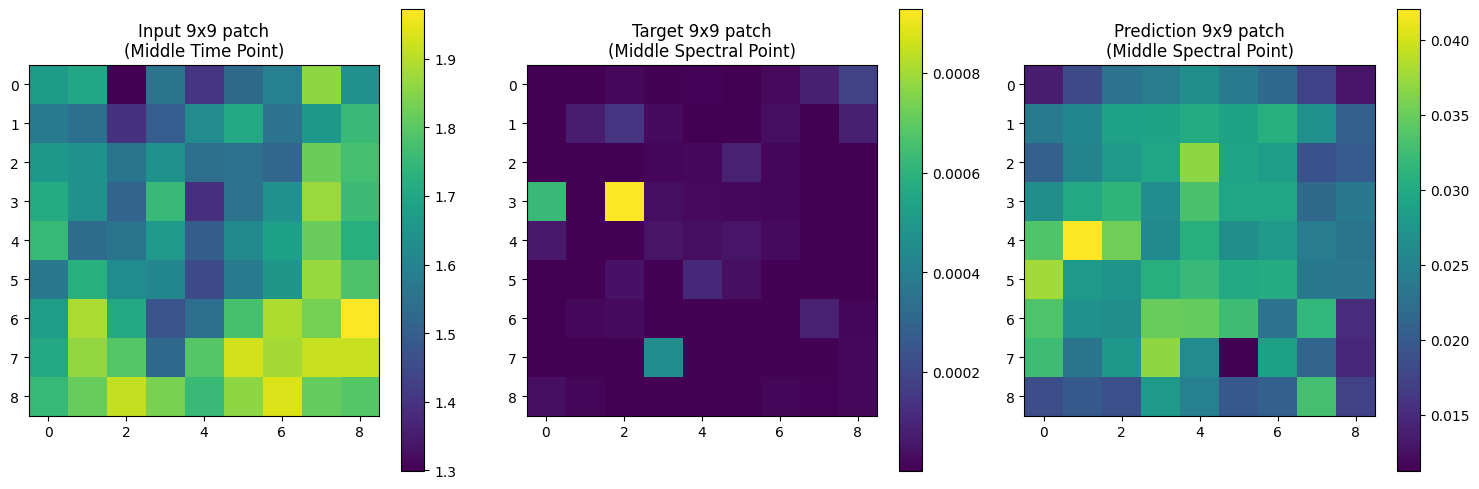

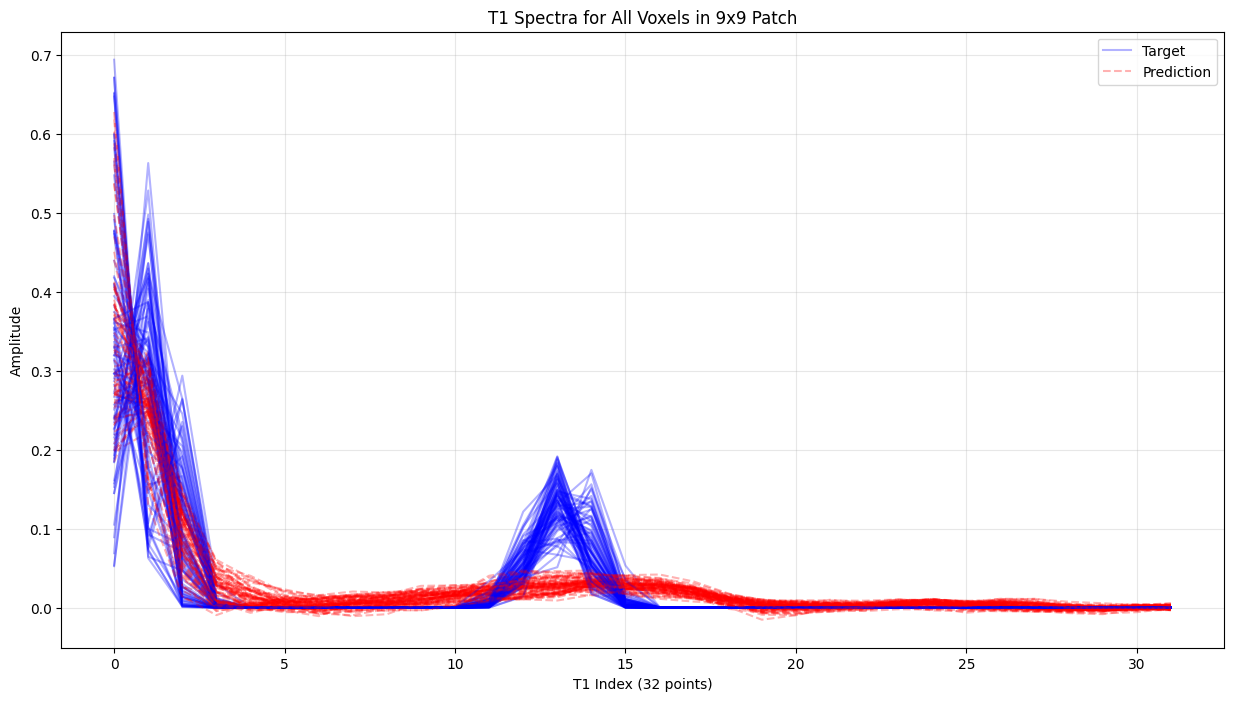

Full 9x9 patch MSE: 0.001380
Full 9x9 patch MAE: 0.019442

Mean Voxel MSE: 0.001380
Std Voxel MSE: 0.000721
Min Voxel MSE: 0.000343
Max Voxel MSE: 0.003912


In [ ]:
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

with torch.no_grad():
    outputs = model(inputs)

inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

example_idx = 0

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(inputs[example_idx, 4, :, :])  # Middle temporal slice (4 out of 8)
plt.title('Input 9x9 patch\n(Middle Time Point)')
plt.colorbar()

plt.subplot(132)
plt.imshow(targets[example_idx, 16, :, :])  # Middle spectral point (16 out of 32)
plt.title('Target 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.subplot(133)
plt.imshow(outputs[example_idx, 16, :, :])  # Middle spectral point
plt.title('Prediction 9x9 patch\n(Middle Spectral Point)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Plot all 81 voxels (9x9) in a single plot
plt.figure(figsize=(15, 8))

# Plot all voxels
for i in range(9):
    for j in range(9):
        plt.plot(targets[example_idx, :, i, j], 'b-', alpha=0.3, label='Target' if i==0 and j==0 else "")
        plt.plot(outputs[example_idx, :, i, j], 'r--', alpha=0.3, label='Prediction' if i==0 and j==0 else "")

plt.title('T1 Spectra for All Voxels in 9x9 Patch')
plt.xlabel('T1 Index (32 points)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print metrics for the whole 9x9 patch
patch_mse = np.mean((targets[example_idx] - outputs[example_idx])**2)
patch_mae = np.mean(np.abs(targets[example_idx] - outputs[example_idx]))
print(f"Full 9x9 patch MSE: {patch_mse:.6f}")
print(f"Full 9x9 patch MAE: {patch_mae:.6f}")

# Calculate statistics of individual voxel MSEs
voxel_mses = []
for i in range(9):
    for j in range(9):
        mse = np.mean((targets[example_idx, :, i, j] - outputs[example_idx, :, i, j])**2)
        voxel_mses.append(mse)

print(f"\nMean Voxel MSE: {np.mean(voxel_mses):.6f}")
print(f"Std Voxel MSE: {np.std(voxel_mses):.6f}")
print(f"Min Voxel MSE: {np.min(voxel_mses):.6f}")
print(f"Max Voxel MSE: {np.max(voxel_mses):.6f}")

In [18]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
final_mae,▁
final_mse,▁
final_psnr,▁
final_r2_score,▁
inference_time_ms,▁
learning_rate,██████████████████████████████▃▃▃▃▃▃▃▃▃▁
memory_usage_mb,▁
model_parameters,▁
peak_detection_accuracy,▁
train_loss,█▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
